# Collaboration and Competition

---

In this notebook, we solve the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/) and [Pytorch](https://pytorch.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {:.4f} [Average: {:.4f}]'.\
                                              format(i, np.max(scores), np.mean(scores)))

Score (max over agents) from episode 1: 0.0000 [Average: -0.0050]
Score (max over agents) from episode 2: 0.0000 [Average: -0.0050]
Score (max over agents) from episode 3: 0.0900 [Average: 0.0450]
Score (max over agents) from episode 4: 0.0900 [Average: 0.0450]
Score (max over agents) from episode 5: 0.0000 [Average: -0.0050]


When finished, you can close the environment.

## Solve: Training the Agent with DDPG

In [6]:
# Create the Agent
agent = Agent(state_size, action_size, random_seed = 2, agent_size = num_agents)

In [7]:
# Gather experience and train the Agent

def ddpg(scores, rollscores, n_episodes = 5000, max_t = 1000, \
         print_every = 20, window = 100, target = 0.5, save_every = 50, stop = True):
    """Deep Deterministic Policy Gradients DDPG  from Pendulum exercise was employed: 
       Params:
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            print_every(int): print update 
    """
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get the current state
        agent.reset()                                     # reset agent noise 
        scores_a1 = 0 
        scores_a2 = 0
        
        for t in range(max_t):
            actions = agent.act(state)                    # select an action   
            action_info = env.step(actions)[brain_name]   # take the action
            next_state = action_info.vector_observations  # get next state
            rewards = action_info.rewards                 # get rewards for each agent
            done = action_info.local_done                 # check if episode is finished
            for idx in range(num_agents):                 # save the experience
                agent.save_experience(state[idx], actions[idx], rewards[idx], next_state[idx], done[idx])
            agent.multi_step(t)                           # train each agent 
            state = next_state                            # roll over states to next time step
            scores_a1 += rewards[0] 
            scores_a2 += rewards[1]
            if np.any(done):
                break
        
        scores.append(max(scores_a1,scores_a2))           # keep track of scores
        
        if i_episode <= window:
            rollscores.append(np.mean(scores))
        else:
            rollscores.append(np.mean(scores[-window:]))
        
        if i_episode % print_every == 0:                  # printing
            print('Episode {}\tAverage Score: {:.4f}'.format(i_episode, rollscores[-1]))
  
        if i_episode % save_every == 0:                   # saving model params
            torch.save(agent.actor_local.state_dict(),  'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if rollscores[-1] >= target and stop:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.\
                                              format(i_episode - window, rollscores[-1]))
            break
    
    print ('\nTraining Completed')

### 1. Targeted Learning

In [8]:
scores = []
rollscores = []
ddpg(scores, rollscores)

Episode 20	Average Score: 0.0100
Episode 40	Average Score: 0.0050
Episode 60	Average Score: 0.0033
Episode 80	Average Score: 0.0025
Episode 100	Average Score: 0.0020
Episode 120	Average Score: 0.0000
Episode 140	Average Score: 0.0000
Episode 160	Average Score: 0.0000
Episode 180	Average Score: 0.0000
Episode 200	Average Score: 0.0000
Episode 220	Average Score: 0.0000
Episode 240	Average Score: 0.0000
Episode 260	Average Score: 0.0000
Episode 280	Average Score: 0.0020
Episode 300	Average Score: 0.0039
Episode 320	Average Score: 0.0116
Episode 340	Average Score: 0.0144
Episode 360	Average Score: 0.0164
Episode 380	Average Score: 0.0173
Episode 400	Average Score: 0.0174
Episode 420	Average Score: 0.0155
Episode 440	Average Score: 0.0166
Episode 460	Average Score: 0.0146
Episode 480	Average Score: 0.0117
Episode 500	Average Score: 0.0097
Episode 520	Average Score: 0.0039
Episode 540	Average Score: 0.0000
Episode 560	Average Score: 0.0000
Episode 580	Average Score: 0.0000
Episode 600	Averag

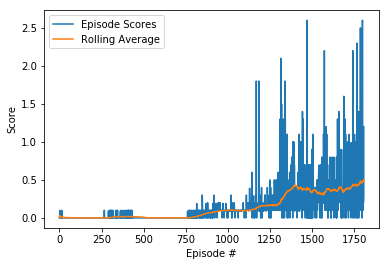

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores)
plt.plot(rollscores)
ax.legend(['Episode Scores', 'Rolling Average'])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 2. (Almost) Unlimited Learning

In [ ]:
ddpg(scores, rollscores, print_every = 50, stop = False)

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores)
plt.plot(rollscores)
ax.legend(['Episode Scores', 'Rolling Average'])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent!

In [11]:
# load the weights from file
newagent = Agent(state_size, action_size, random_seed = 2, agent_size = num_agents)
newagent.actor_local.load_state_dict(torch.load('Weights/checkpoint_actor.pth'))
newagent.critic_local.load_state_dict(torch.load('Weights/checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]    # reset the environment
states = env_info.vector_observations                 # get the current state
newscores = np.zeros(num_agents)                      # initialize the score
while True:
    actions = newagent.act(states, add_noise = False) # select an action for each agent
    actions = np.clip(actions, -1, 1)                 # all actions between -1 and 1      
    env_info = env.step(actions)[brain_name]          # send the action to the environment                  
    next_states =  env_info.vector_observations       # get the next state
    rewards = env_info.rewards                        # get the rewards
    dones =env_info.local_done                        # see if episode has finished
    newscores += rewards                              # update the score for each agent
    states = next_states                              # roll over the state to next time step
    if np.any(dones):                                 # exit loop if episode finished
        break
    
print('Total score (averaged over agents) in this episode: {:.4f}'.format(np.mean(newscores)))

Total score (averaged over agents) in this episode: 2.6000


In [15]:
env.close()